<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [1]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np

In [2]:
from google.colab import drive

drive.mount('/content/drive')
!tar -xvf drive/MyDrive/capsule.tar.gz capsule

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
tar: drive/MyDrive/capsule.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [3]:
# import zipfile
# import os

# zip_path = '/content/drive/MyDrive/Colab Notebooks/deepLearning/capsule.zip'
# extract_dir = '/content/drive/MyDrive/Colab Notebooks/deepLearning/capsule'

# if not os.path.exists(extract_dir):
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_dir)
#     print("解壓完成！")
# else:
#     print("已解壓，跳過。")

In [4]:
file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/deepLearning/capsule/*/*/*.png')
# /content/drive/MyDrive/Colab Notebooks/deepLearning/capsule.zip
file_paths = sorted([path for path in file_paths if path.split('/')[-1] in [f'{i:03}.png' for i in range(6)]])

In [5]:
file_paths

['/content/drive/MyDrive/Colab Notebooks/deepLearning/capsule/test/crack/000.png',
 '/content/drive/MyDrive/Colab Notebooks/deepLearning/capsule/test/crack/001.png',
 '/content/drive/MyDrive/Colab Notebooks/deepLearning/capsule/test/crack/002.png',
 '/content/drive/MyDrive/Colab Notebooks/deepLearning/capsule/test/crack/003.png',
 '/content/drive/MyDrive/Colab Notebooks/deepLearning/capsule/test/crack/004.png',
 '/content/drive/MyDrive/Colab Notebooks/deepLearning/capsule/test/crack/005.png',
 '/content/drive/MyDrive/Colab Notebooks/deepLearning/capsule/test/faulty_imprint/000.png',
 '/content/drive/MyDrive/Colab Notebooks/deepLearning/capsule/test/faulty_imprint/001.png',
 '/content/drive/MyDrive/Colab Notebooks/deepLearning/capsule/test/faulty_imprint/002.png',
 '/content/drive/MyDrive/Colab Notebooks/deepLearning/capsule/test/faulty_imprint/003.png',
 '/content/drive/MyDrive/Colab Notebooks/deepLearning/capsule/test/faulty_imprint/004.png',
 '/content/drive/MyDrive/Colab Notebooks/d

In [6]:
all_data = []

for img in tqdm(file_paths):
    img = cv2.imread(img)
    img = img[..., ::-1]
    all_data.append(img)

all_data = np.stack(all_data)
print(all_data.shape)

  0%|          | 0/42 [00:00<?, ?it/s]

(42, 1000, 1000, 3)


Classes: ['crack', 'faulty_imprint', 'good', 'poke', 'scratch', 'squeeze']


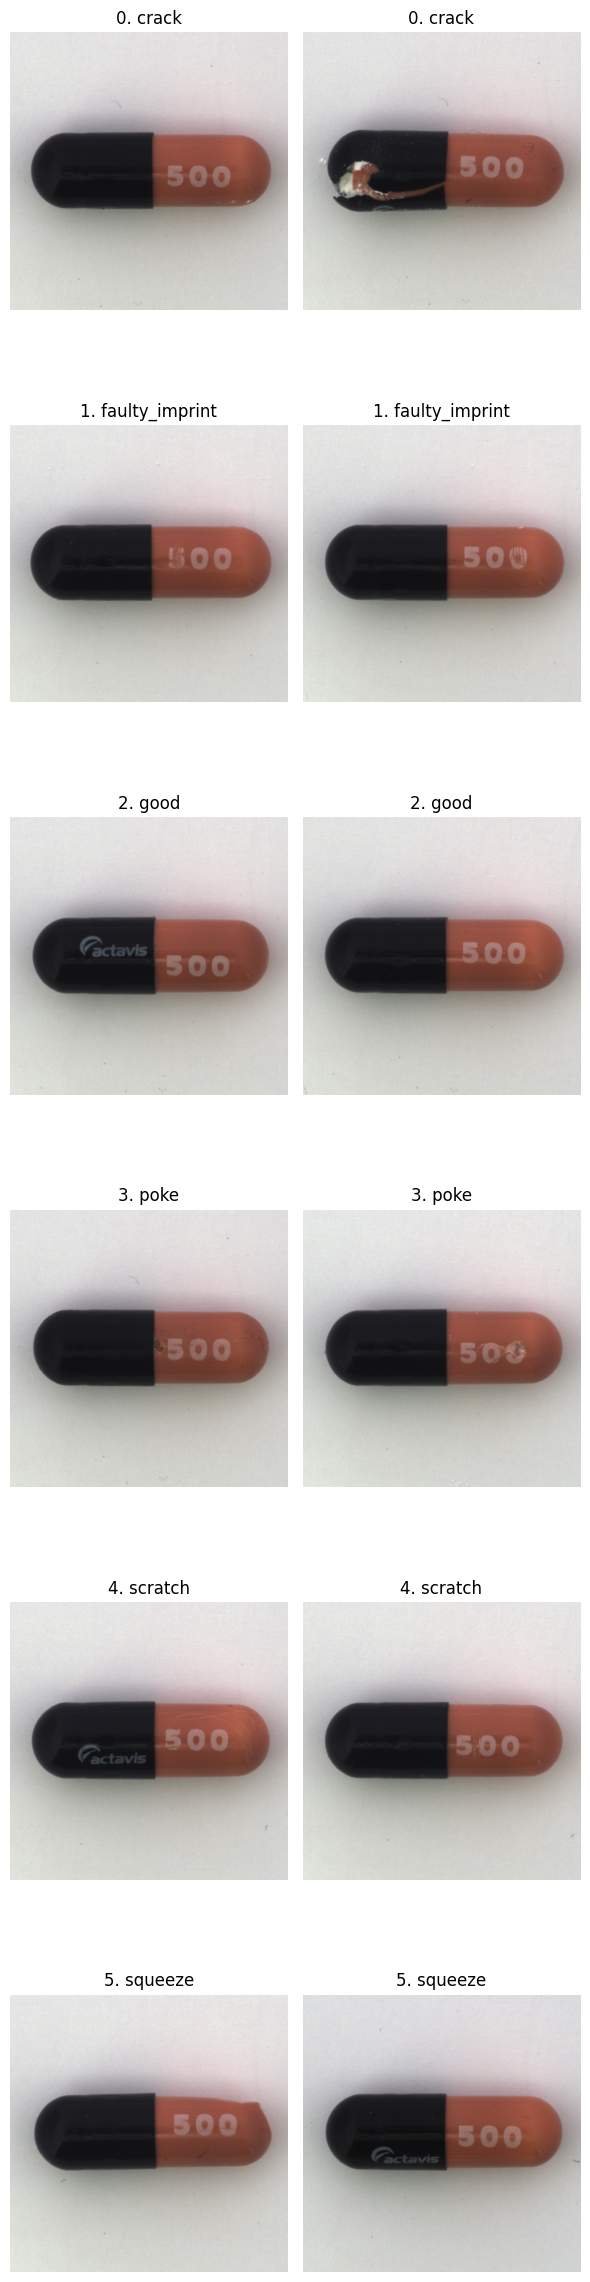

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# classes = sorted(set([path.split('/')[1] for path in file_paths]))
classes = sorted(set([path.split('/')[8] for path in file_paths]))
print(f'Classes: {classes}')

images_per_class = len(all_data) // len(classes)
fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)))

for i, class_name in enumerate(classes):
    index = i * images_per_class
    for j in range(2):
        axs[i, j].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

## A. Data Loading and Preprocessing

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

num_classes = 6 # 8
images_per_class = 20 # 10
train_images_per_class = int(images_per_class * 0.8)
val_images_per_class = int(images_per_class * 0.2)

x_train = []
x_val = []

for i in range(num_classes):
    start_index = i * images_per_class
    x_train.extend(all_data[start_index:start_index + train_images_per_class])
    x_val.extend(all_data[start_index + train_images_per_class:start_index + images_per_class])

# The shape changes from (batch_size, height, width, channels) to (batch_size, channels, height, width)
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))

y_train = np.concatenate([np.full(train_images_per_class, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(val_images_per_class, i) for i in range(num_classes)])

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of x_train: (34, 3, 1000, 1000)
Shape of x_val: (8, 3, 1000, 1000)
Shape of y_train: (96,)
Shape of y_val: (24,)


In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.AutoAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # 隨機裁切大小變動
        transforms.RandomHorizontalFlip(p=0.5),               # 水平翻轉
        transforms.RandomVerticalFlip(p=0.3),                 # 垂直翻轉（小機率）
        transforms.RandomRotation(degrees=20),                # 隨機旋轉 ±20 度
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.02),  # 色彩變化更明顯
        transforms.RandomGrayscale(p=0.1),                    # 有小機率轉為灰階
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # 模糊處理模擬失焦
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.AutoAugment(),
        transforms.ToTensor(),
    ]
)

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0))
        return self.transform(Image.fromarray(new_x)), self.y[idx]

In [10]:
batch_size = 16

train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

## B. Defining Neural Networks

In [11]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

model = models.resnet18(weights='IMAGENET1K_V1')
# model = models.resnet50(pretrained=True)

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.parameters():
    param.requires_grad = False

# 解凍最後幾層（Layer4 + fc），可自由調整
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

# 修改全連接層（根據你類別數）
num_classes = 6  # 5 種缺陷 + 1 種 good
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

# num_ftrs = model.fc.in_features
num_class = 6

# change # of class from 1000 into 8 in the last layer
# model.fc = nn.Linear(num_ftrs, num_class)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='sum', weight=None):
        """
        alpha: 樣本平衡因子（可為 1 或 tensor）
        gamma: focusing 參數（越大越注重難分樣本）
        weight: 類別權重（如你有 class imbalance 可傳入）
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.weight = weight

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='sum', weight=self.weight)
        pt = torch.exp(-ce_loss)  # pt = softmax 預測機率
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

## C. Training the Neural Network

In [13]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 80
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

# criterion = nn.CrossEntropyLoss()
weight = torch.tensor([5.0, 5.0, 1.0, 5.0, 5.0, 5.0]).cuda()
criterion = FocalLoss(alpha=1.2, gamma=2.5, weight=weight)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = (images) / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = (images) / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1/80, Train loss: 108.7648, Train acc: 29.4118%, Val loss: 79.0345, Val acc: 50.0000%, Best Val loss: 79.0345 Best Val acc: 50.00%
Epoch 2/80, Train loss: 87.4149, Train acc: 52.9412%, Val loss: 73.9548, Val acc: 50.0000%, Best Val loss: 73.9548 Best Val acc: 50.00%
Epoch 3/80, Train loss: 74.3662, Train acc: 52.9412%, Val loss: 68.7006, Val acc: 50.0000%, Best Val loss: 68.7006 Best Val acc: 50.00%
Epoch 4/80, Train loss: 64.1806, Train acc: 52.9412%, Val loss: 64.1603, Val acc: 50.0000%, Best Val loss: 64.1603 Best Val acc: 50.00%
Epoch 5/80, Train loss: 57.6019, Train acc: 58.8235%, Val loss: 60.0532, Val acc: 50.0000%, Best Val loss: 60.0532 Best Val acc: 50.00%
Epoch 6/80, Train loss: 52.2802, Train acc: 58.8235%, Val loss: 54.5863, Val acc: 50.0000%, Best Val loss: 54.5863 Best Val acc: 50.00%
Epoch 7/80, Train loss: 55.2501, Train acc: 47.0588%, Val loss: 50.1600, Val acc: 50.0000%, Best Val loss: 50.1600 Best Val acc: 50.00%
Epoch 8/80, Train loss: 53.5009, Train acc: 47.

### Visualizing model performance

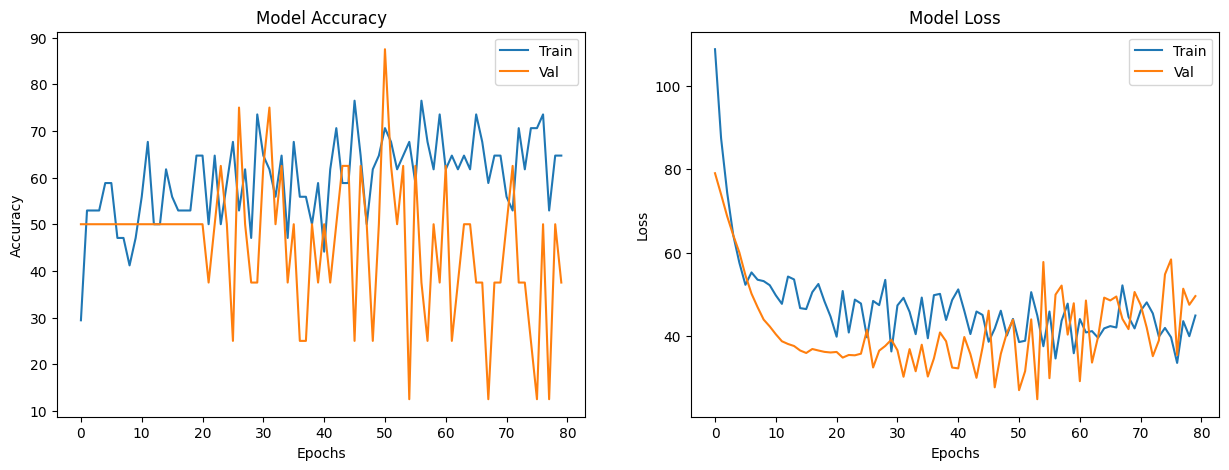

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [15]:
# test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

In [16]:
# from torchvision.datasets import ImageFolder
# from torch.utils.data import DataLoader

# test_dataset = ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/deepLearning/capsule/test', transform=test_transform)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [17]:
# 定義 class 順序與 index（需與訓練時相同）
correct_order = ['good', 'crack', 'faulty_imprint', 'poke', 'scratch', 'squeeze']
# 建立映射
class_to_idx = {class_name: i for i, class_name in enumerate(correct_order)}

# 這樣你就可以用 test_dataset.classes 與你模型訓練時對齊


In [18]:
# print(test_dataset.class_to_idx)
# # 可能結果：{'good': 0, 'crack': 1, 'faulty_imprint': 2, ...}
# ['crack', 'faulty_imprint', 'good', 'poke', 'scratch', 'squeeze']

In [20]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    # for images, labels in val_loader:
    for images, labels in val_loader:

        images = images.cuda()
        # images = (images) / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Test accuracy is 50.0%
